In [3]:
import sys
import os
sys.path.append('../../workbooks/')

import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches
from matplotlib import colors
from matplotlib.transforms import Bbox

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scalebar

import seaborn as sns 

import calendar
from datetime import timedelta

import pandas as pd
from pandas.io.json import json_normalize

import rasterio as rio
from rasterio import plot
from rasterio.plot import show

import json

from shapely import geometry

from IPython.display import Markdown as md

import numpy as np

%matplotlib inline

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

def add_backbox(fig, axes, color, pad=0):
    extent = Bbox.union([full_extent(ax, pad=pad) for ax in axes])
    extent = extent.transformed(fig.transFigure.inverted())

    # We can now make the rectangle in figure coords using the "transform" kwarg.
    rect = patches.Rectangle([extent.xmin, extent.ymin], extent.width, extent.height,
                     facecolor=color, edgecolor='none', zorder=-1, alpha=0.3 ,
                     transform=fig.transFigure)
    fig.patches.append(rect)





# Study Sites Climatological Comparisons
[Tony Cannistra](http://www.anthonycannistra.com), 2020

This notebook creates **Figure X** in Cannistra et al, 2020, comparing the climates of our two primary study sites (Tuolumne, CA and Upper Gunnison, CO) along three dimensions:
* Temperature
* Precipitation
* SWE Accumulation

Data are derived from reanalyses or directly from observational records. 

## Setup


In [5]:
DANA_ELEVATION = 2987 # meters
LOST_TRAIL_ELEVATION = 2804 #meters
MIN_GOOD_DAYS = 200 # Minimum number of days of non-NaN SWE data for a water year to be plotted
ROLL_MEAN_WINDOW_SIZE_DAYS = 10 # window size for rolling mean computation (days)
CONUS_WEST_BBOX = [-126.1, -100.0, 31, 49] # bounding box of CONUS west
CONUS_WEST_PROJECTION = ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795)
GUNNISON_POINT = (-107.14, 39.08)
TUOLUMNE_POINT = (-119.257, 37.897)

We create a function which assigns the water year to each date. 

In [6]:
def assign_wy(date):
    if not pd.isna(date):
        if date.month>=10:
            return(pd.datetime(date.year+1,1,1).year)
        else:
            return(pd.datetime(date.year,1,1).year)
    else: 
        return pd.NaT

And another which converts the water year date (WYD) to day of year (DOY). We use this for plotting (to label X axis) as a Matplotlib `Formatter` (here `format_doy`).

In [165]:
def wyd_to_doy(wyd):
    if(wyd > 366): return np.nan
    doy = pd.datetime(1999, 10, 1) + timedelta(days=int(wyd))
    return"{} {}".format(calendar.month_abbr[doy.month], doy.day)

def format_doy(value, tick_number):
    # find number of multiples of pi/2
    return(wyd_to_doy(value))

## SWE
### Tuolumne
These figures contain processed snow pillow data from **XXXX et al**. 

In [241]:
dana_snotel = pd.read_csv("TUM-DAN_Pillow_SWE.csv", parse_dates=[0]).rename({
    "Date [yyyy-mm-dd]": "Date",
    " Dana Meadows Pillow SWE [mm]" : "DanaSWE"
}, axis=1).drop(" Tuolumne Meadows Pillow SWE [mm]", axis=1)

dana_snotel.DanaSWE = pd.to_numeric(dana_snotel.DanaSWE.str.strip(), errors='coerce') / 10 # convert to cm
# dana_snotel.loc[dana_snotel.VALUE == '---', 'VALUE']= pd.np.nan
# dana_snotel.VALUE = pd.to_numeric(dana_snotel.VALUE)

In [242]:
dana_snotel.columns

Index(['Date', 'DanaSWE'], dtype='object')

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


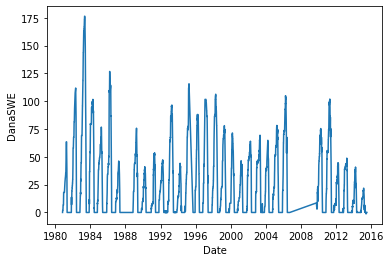

In [10]:
sns.lineplot(x='Date', y='DanaSWE', data=dana_snotel)

#### Assign Water year and remove rows with NaN SWE values

In [11]:
dana_snotel['WY'] = dana_snotel['Date'].apply(assign_wy)

In [12]:
dana_snotel['Date'].min().year

1979

In [13]:
dana_snotel = dana_snotel.dropna(axis=0, subset=['DanaSWE'])

In [14]:
dana_snotel['Date'].min().year

1980

#### Assign Water Year Day 

In [15]:
dana_snotel['wyd'] = dana_snotel.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

In [16]:
md(f"#### Remove entire water years with fewer than *N* data points (N = {MIN_GOOD_DAYS})")

#### Remove entire water years with fewer than *N* data points (N = 200)

In [17]:
good_years = [_.name for i, _ in (dana_snotel.groupby("WY").count() > MIN_GOOD_DAYS).iterrows() if _.wyd]
cleaned_years = dana_snotel[dana_snotel.WY.isin(good_years)]

#### Visualize Individual Data 

28


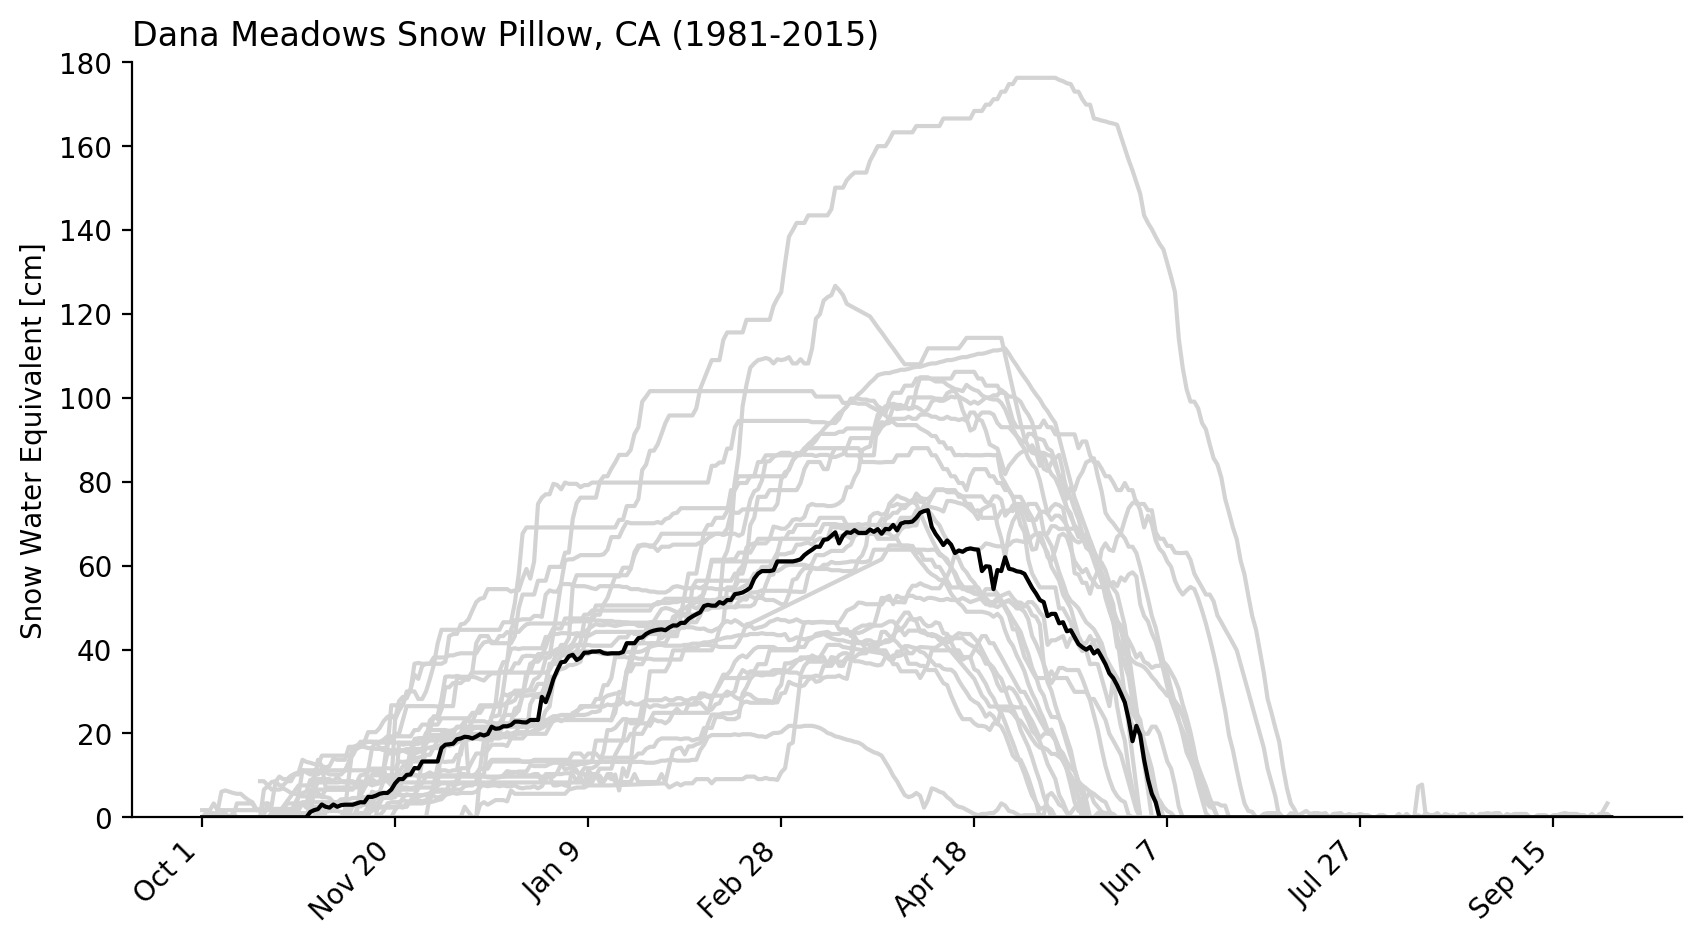

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

print(len(cleaned_years.groupby("WY")))
for group in cleaned_years.groupby("WY"):
    ax.plot(group[1].groupby("wyd").median().index.days, group[1].groupby("wyd").median().DanaSWE.values, color='lightgray')
    
study_year = cleaned_years[cleaned_years.WY == 2018]
ax.plot(study_year.groupby('wyd').median().index.days, study_year.groupby('wyd').median().DanaSWE.values, color='red')
    
ax.plot(cleaned_years.groupby("wyd").median().index.days, cleaned_years.groupby("wyd").median()['DanaSWE'].values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 180])
ax.set_ylabel("Snow Water Equivalent [cm]")
minyear = cleaned_years['Date'].min().year
maxyear = cleaned_years['Date'].max().year
ax.set_title("Dana Meadows Snow Pillow, CA ({}-{})".format(minyear, maxyear), loc='left')
sns.despine()

Set minimum number of observations for a given year to be plotted?

### Upper Gunnison
We largely repeat the above analysis for the Upper Gunnison area, using data directly from the NRCS SNOTEL site "North Lost Trail [669]"

In [19]:
co_snotel = pd.read_csv("SNOTEL669_WTEQ.txt", comment='#', parse_dates=[0])

In [20]:
co_snotel.columns

Index(['Date', 'North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values'], dtype='object')

In [21]:
co_snotel = co_snotel.rename({"North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values" : "WTEQ"}, axis=1)

In [22]:
co_snotel

,Date,WTEQ
0,1985-09-18,0.0
1,1985-09-19,0.0
2,1985-09-20,0.0
3,1985-09-21,0.0
4,1985-09-22,0.0
...,...,...
12581,2020-02-28,14.6
12582,2020-02-29,14.7
12583,2020-03-01,14.7
12584,2020-03-02,15.1


In [23]:
# convert to cm
co_snotel.WTEQ = co_snotel.WTEQ * 2.54

In [24]:
co_snotel['WY'] = co_snotel.Date.apply(assign_wy)

In [25]:
co_snotel['wyd'] = co_snotel.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

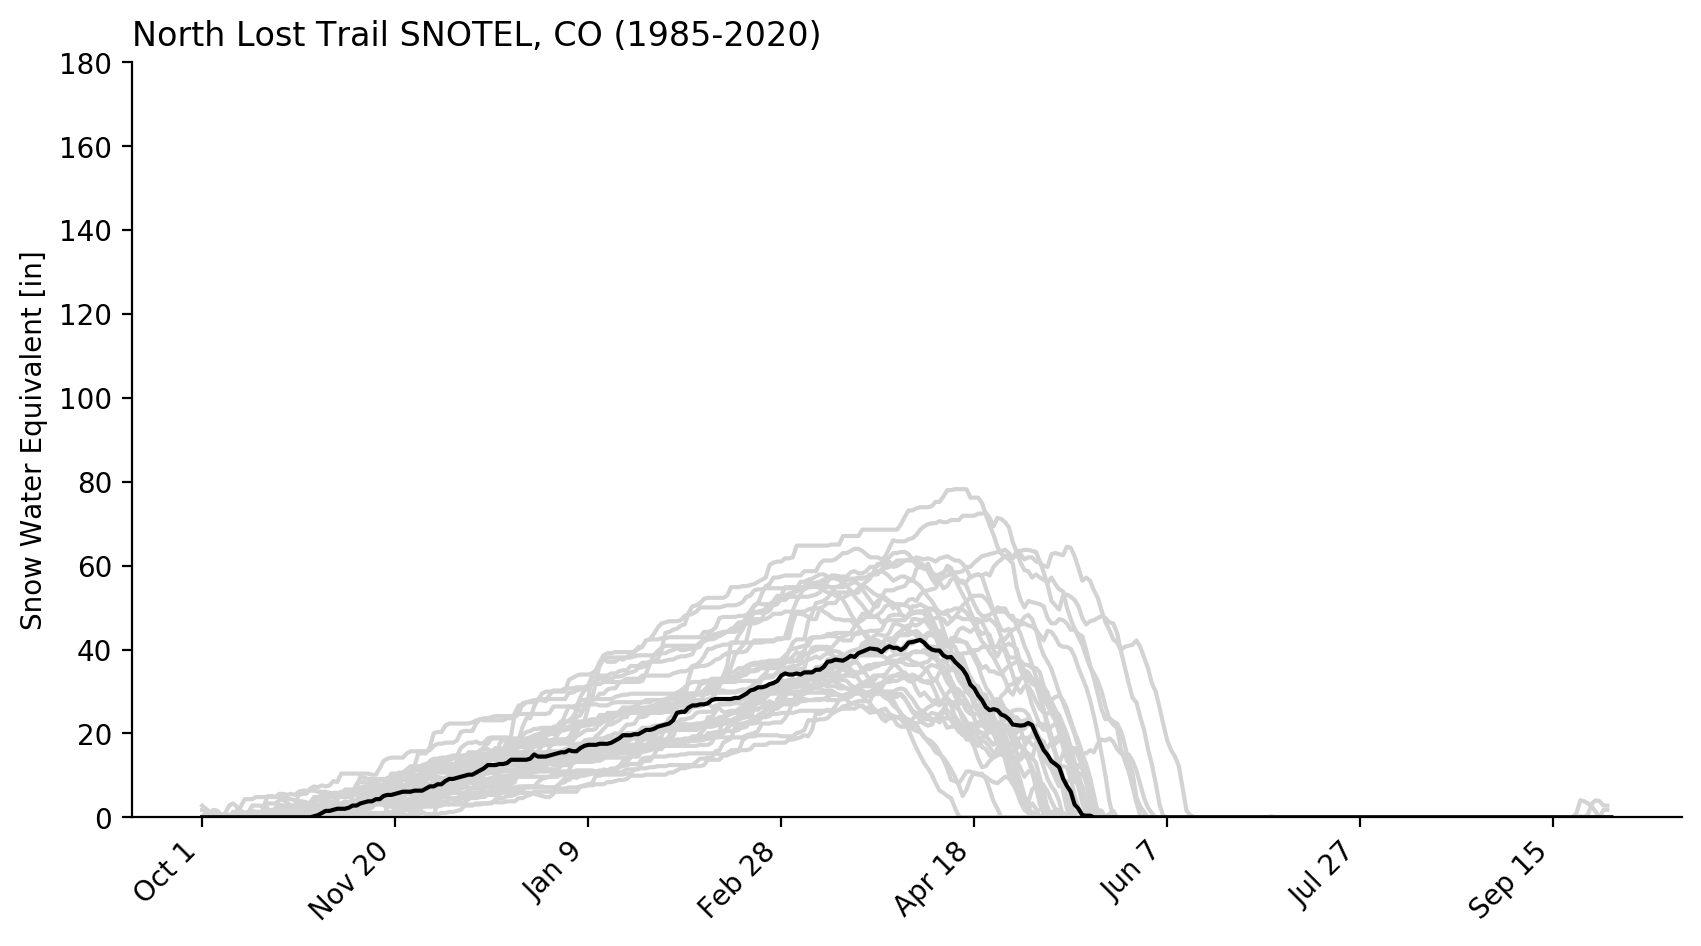

In [26]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
snotel = co_snotel
for group in snotel.groupby("WY"):
    ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").median().WTEQ.values, color='lightgray')
    
ax.plot(snotel.groupby("wyd").mean().index.days, snotel.groupby("wyd").median().WTEQ.values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 180])
ax.set_ylabel("Snow Water Equivalent [in]")
ax.set_title("North Lost Trail SNOTEL, CO (1985-2020)", loc='left')
sns.despine()

## Generalized Plotting Function
Here's a generalized snow plotting function from what we've learned above: 

In [27]:
def plot_snow(data, snowcol, title, ax, color = 'black', sharey=False, lighten=0.3):
    for group in data.groupby("WY"):
        ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").median()[snowcol].values, color=lighten_color(color, amount=lighten))
    
    ax.plot(data.groupby("wyd").mean().index.days, data.groupby("wyd").median()[snowcol].values, color=color)

    locs, labels = plt.xticks()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
#     plt.setp(ax.get_xticklabels(), ha="right", rotation=0)
    ax.set_ylim([0, 180])
    if not sharey:
        ax.set_ylabel("SWE [cm]")
    ax.set_title(title, loc='left')
    sns.despine()

## Temperature and Precipitation
### Tuolumne
Here we use a spatially interpolated climatological dataset from **XXXX et al**>

In [28]:
dana_temp = pd.read_csv("Dana_Meadows_model_forcing_dataset.csv", parse_dates=[1])
dana_temp.columns = dana_temp.columns.str.strip()

In [29]:
dana_temp.head()

,date_time_UTC,date_time_PST,T_deg_C,Wind_m_per_s,RH_percent,SWdwnGapFill,LWdwnMTCLIM,precip_m
0,2002/10/01 07:00:00,2002-09-30 23:00:00,-5.56,0.447,91,0.0,220.74,0.0
1,2002/10/01 08:00:00,2002-10-01 00:00:00,-5.56,0.447,81,0.0,220.74,0.0
2,2002/10/01 09:00:00,2002-10-01 01:00:00,-5.56,0.447,52,0.0,220.74,0.0
3,2002/10/01 10:00:00,2002-10-01 02:00:00,-6.11,0.447,44,0.0,218.94,0.0
4,2002/10/01 11:00:00,2002-10-01 03:00:00,-6.67,0.447,41,0.0,217.14,0.0


#### Resample the hourly data to Daily 
We use a **mean** resampling for the temperature and a **sum** resampling for precipitation:

In [111]:
dana_temp_daily = dana_temp.set_index('date_time_PST').resample('D').mean().reset_index()
dana_pcp_daily = dana_temp.set_index('date_time_PST').resample('D').sum().reset_index()

In [112]:
# assign WY and WYD
dana_temp['WY'] = dana_temp['date_time_PST'].apply(assign_wy)
dana_temp['wyd'] = dana_temp.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)


In [113]:
dana_temp_daily['WY'] = dana_temp_daily['date_time_PST'].apply(assign_wy)
dana_temp_daily['wyd'] = dana_temp_daily.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)
dana_pcp_daily['WY'] = dana_pcp_daily['date_time_PST'].apply(assign_wy)
dana_pcp_daily['wyd'] = dana_pcp_daily.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

In [47]:
md(f"#### Compute a rolling mean (window size = {ROLL_MEAN_WINDOW_SIZE_DAYS} days) for temperature across the water year")

#### Compute a rolling mean (window size = 10 days) for temperature across the water year

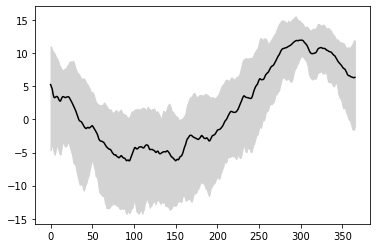

In [48]:
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = dana_temp_daily.groupby("wyd").mean()['T_deg_C'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean()
rolling_wy_max = dana_temp_daily.groupby("wyd").max()['T_deg_C'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean()
rolling_wy_min = dana_temp_daily.groupby("wyd").min()['T_deg_C'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean()
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')


#### Precip a little more complex:

1. Compute water year day means
2. Assign pseudo-dates to water year day values
3. Resample to get weekly sums of WYD means. 
4. Reassign WYD for plotting .


In [127]:
dana_wyd_means = dana_pcp_daily.groupby(dana_pcp_daily.wyd).mean().reset_index()
dana_wyd_means['pseudo-date-wyd'] = dana_wyd_means.wyd.dt.days.replace(to_replace=range(0, 366), value=pd.date_range(start='10/1/1999', end='9/30/2000'))
dana_pcp_wyd_weekly = dana_wyd_means[['precip_m', 'pseudo-date-wyd']].resample('W', on='pseudo-date-wyd').sum().reset_index()
dana_pcp_wyd_weekly['wyd'] = dana_pcp_wyd_weekly.apply(lambda x: x['pseudo-date-wyd'] - pd.datetime(1999, 10, 1), axis=1)

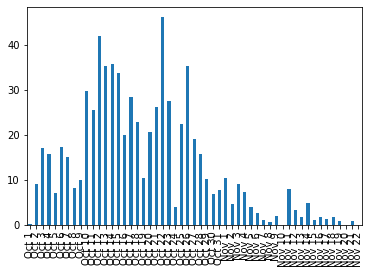

In [166]:
ax = plt.subplot()
(dana_pcp_wyd_weekly.precip_m * 1000).plot(kind='bar', ax=ax)

ax.set_xticklabels(labels=dana_pcp_wyd_weekly.wyd)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))

plt.show()


In [175]:
len(dana_pcp_wyd_weekly.wyd.dt.days.sort_values().values)

53

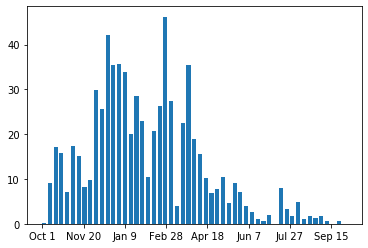

In [180]:
ax = plt.subplot()
ax.bar(dana_pcp_wyd_weekly.wyd.dt.days, dana_pcp_wyd_weekly.precip_m * 1000, width=5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))


### Upper Gunnison
We use the NRCS SNOTEL "North Lost Trail [669]" site for temperature and preciptation measurements, as above. 


In [209]:
co_tavg = pd.read_csv("SNOTEL669_TAVG.txt", comment='#', parse_dates=['Date'])
co_tavg = co_tavg.rename({"North Lost Trail (669) Air Temperature Average (degF)": "TAVG"}, axis=1)

In [210]:
# convert to C
co_tavg.TAVG = (co_tavg.TAVG - 32) * (5/9)

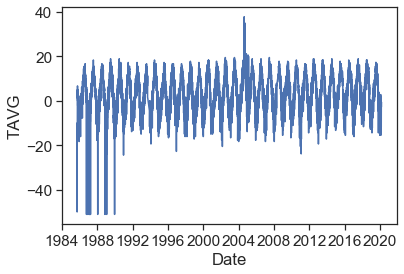

In [211]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

The plot above shows some data anomalies, so we apply a threshold of $-40^\circ\text{C}$. 

In [212]:
co_tavg.loc[co_tavg.TAVG < -40, 'TAVG'] = pd.np.nan
co_tavg = co_tavg.dropna(subset=["TAVG"])

And compute a rolling mean. 

In [213]:
co_tavg.TAVG = co_tavg.TAVG.rolling(10).mean()

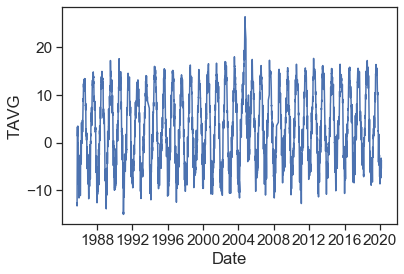

In [214]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

In [215]:
# add WY and WYD
co_tavg['WY'] = co_tavg.Date.apply(assign_wy)
co_tavg['wyd'] = co_tavg.apply(lambda x: x.Date - pd.datetime(x.WY - 1, 10, 1), axis=1)

#### As above, compute a rolling mean across the water year days. 

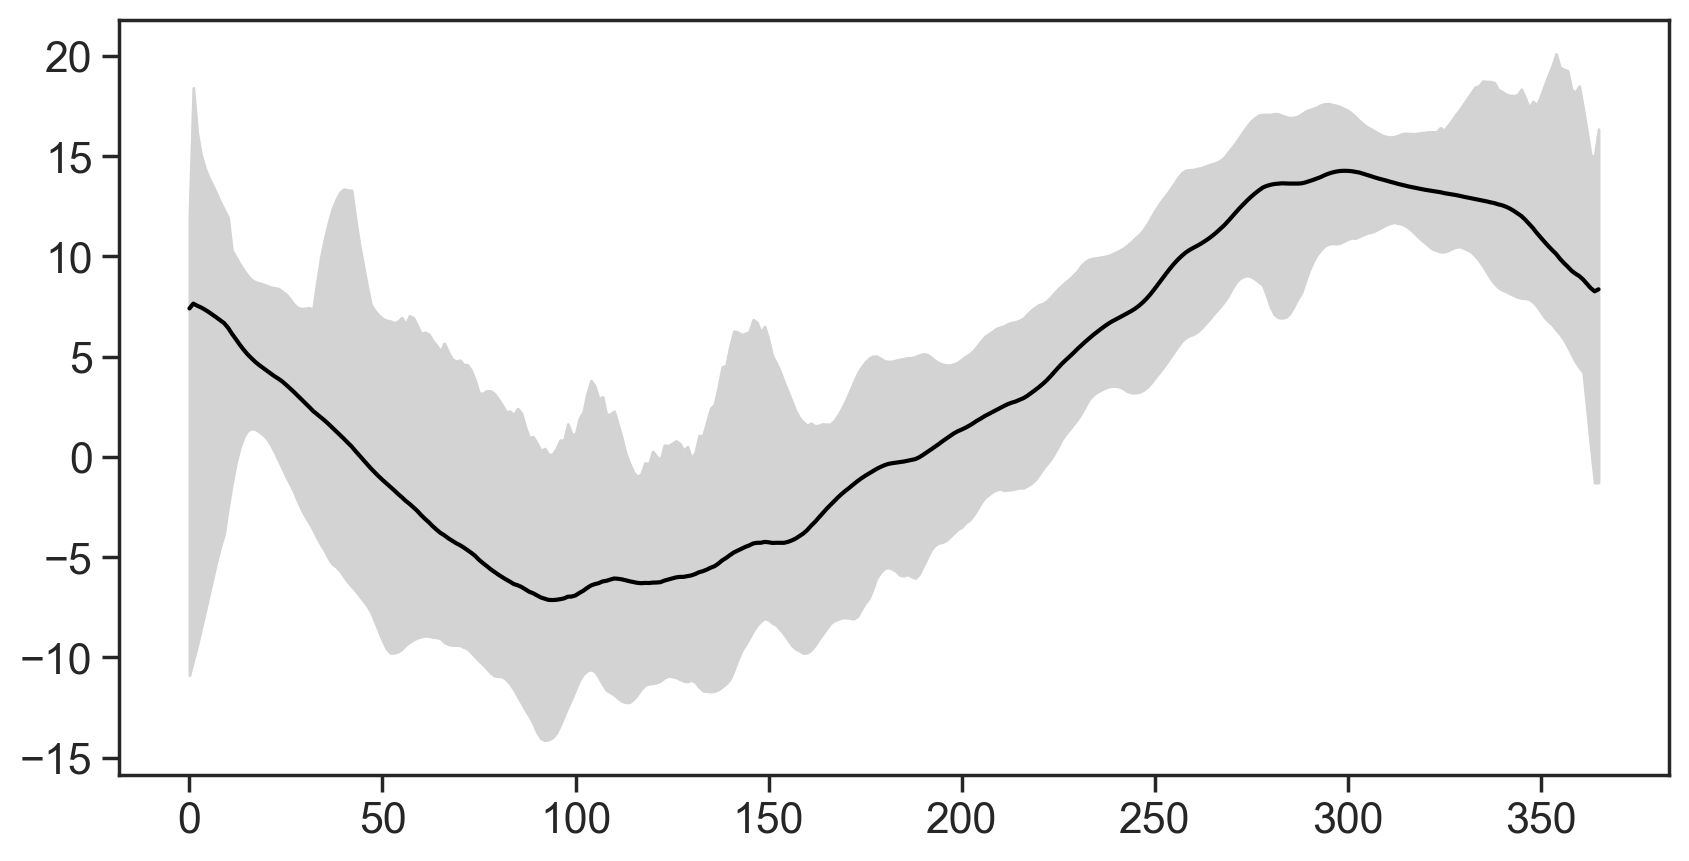

In [216]:
fig = plt.figure(figsize=(10,5), dpi=200)
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = co_tavg.groupby("wyd").mean()['TAVG'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=1).mean()
rolling_wy_max = co_tavg.groupby("wyd").max()['TAVG'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=1).mean()
rolling_wy_min = co_tavg.groupby("wyd").min()['TAVG'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=1).mean()
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')

#### Same as above for precipitation

In [188]:
co_precip = pd.read_csv("SNOTEL669_PRECIP.txt", comment='#', parse_dates=['Date']).rename({
    "North Lost Trail (669) Precipitation Increment - Snow-adj (in)" : 'pcp_adjusted',
    "North Lost Trail (669) Precipitation Increment (in)": 'pcp',
    "North Lost Trail (669) Precipitation Accumulation (in) Start of Day Values" : 'pcp_accum'
}, axis=1)

# convert to meters
for col in ["pcp_accum", 'pcp', 'pcp_adjusted']:
    co_precip.loc[co_precip.index, col] = co_precip[col] * 0.0254

In [182]:
co_precip.head()

,Date,pcp_accum,pcp,pcp_adjusted
0,1985-10-01,0.0,0.0,0.0
1,1985-10-02,0.0,0.0,0.0
2,1985-10-03,0.0,0.0,0.0
3,1985-10-04,0.0,0.0,0.0
4,1985-10-05,0.0,0.0,0.0


In [189]:
## Assign WY and WYD
co_precip['WY'] = co_precip['Date'].apply(assign_wy)
co_precip['wyd'] = co_precip.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

In [190]:
co_precip_wyd_means = co_precip.groupby(co_precip.wyd).mean().reset_index()
co_precip_wyd_means['pseudo-date-wyd'] = co_precip_wyd_means.wyd.dt.days.replace(to_replace=range(0, 366), value=pd.date_range(start='10/1/1999', end='9/30/2000'))
co_precip_wyd_weekly = co_precip_wyd_means[['pcp_adjusted', 'pseudo-date-wyd']].resample('W', on='pseudo-date-wyd').sum().reset_index()
co_precip_wyd_weekly['wyd'] = co_precip_wyd_weekly.apply(lambda x: x['pseudo-date-wyd'] - pd.datetime(1999, 10, 1), axis=1)

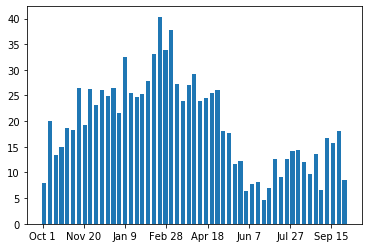

In [191]:
ax = plt.subplot()
ax.bar(co_precip_wyd_weekly.wyd.dt.days, co_precip_wyd_weekly.pcp_adjusted * 1000, width=5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))


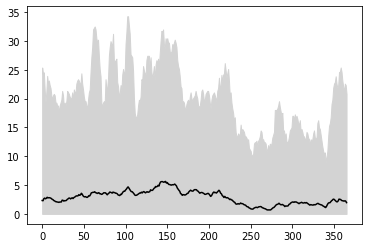

In [91]:
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = co_precip.groupby("wyd").mean()['pcp_adjusted'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean() * 1000
rolling_wy_max = co_precip.groupby("wyd").max()['pcp_adjusted'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean() * 1000
rolling_wy_min = co_precip.groupby("wyd").min()['pcp_adjusted'].rolling(ROLL_MEAN_WINDOW_SIZE_DAYS, min_periods=0).mean() * 1000
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')


## Create a generalized temperature plotting procedure:

In [208]:
def plot_temp(data, tempcol, ax,color='black', roll=10):
    rolling_wy_mean = data.groupby("wyd").mean()[tempcol].rolling(roll, min_periods=0).mean()
    rolling_wy_max = data.groupby("wyd").max()[tempcol].rolling(roll, min_periods=0).mean()
    rolling_wy_min = data.groupby("wyd").min()[tempcol].rolling(roll, min_periods=0).mean()
    ax.plot(range(0, 366), rolling_wy_mean, color=color)
    ax.fill_between(
        range(0, 366),
        rolling_wy_max,
        rolling_wy_min,
    color=color, alpha=0.1)
    locs, labels = ax.get_xticks(), ax.get_xticklabels()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
    sns.despine(ax=ax)


& test: 

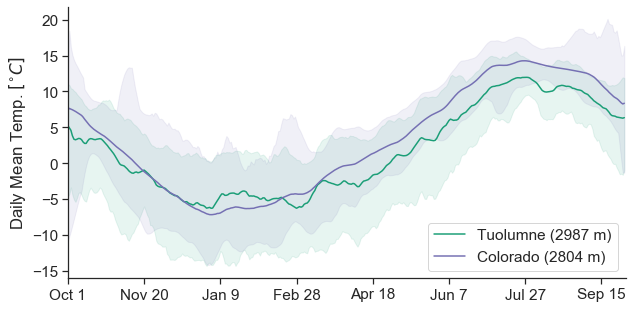

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="ticks", font_scale=1.4)


CA_color = "#1b9e77"
CO_color = "#7570b3"

plot_temp(dana_temp_daily, 'T_deg_C', ax=ax, color=CA_color)
plot_temp(co_tavg, "TAVG", ax=ax, color=CO_color)

ax.set_xlim([0, 366])

locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))

ax.legend(handles=[
    lines.Line2D([],[], color=CA_color, label=f'Tuolumne ({DANA_ELEVATION} m)')  ,
    lines.Line2D([],[], color=CO_color, label=f'Colorado ({LOST_TRAIL_ELEVATION} m)')
], loc='lower right')

ax.set_ylabel("Daily Mean Temp. $[^{\circ}C]$")

sns.despine()

## Create a genralized precipitation plotting procedure: 

In [95]:
def plot_precip(data, precip_col, ax, color='black', roll=10):
    rolling_wy_mean = data.groupby("wyd").mean()[precip_col].rolling(roll, min_periods=0).mean() * 1000
    ax.plot(range(0, 366), rolling_wy_mean, color=color)
    locs, labels = ax.get_xticks(), ax.get_xticklabels()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
    sns.despine(ax=ax)



In [234]:
def plot_precip(data, precip_col, ax, color='black', alpha=1):
    ax.bar(data.wyd.dt.days, data[precip_col] * 1000, width=7, color=color, alpha=alpha)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
    sns.despine(ax=ax)


& test: 

Text(0, 0.5, 'Precip. [mm]')

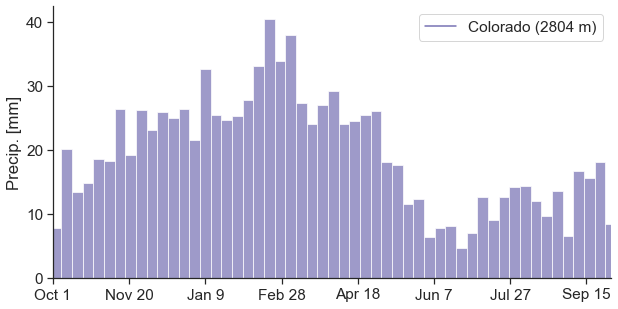

In [235]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="ticks", font_scale=1.4)


CA_color = "#1b9e77"
CO_color = "#7570b3"

# plot_precip(dana_pcp_daily, "precip_m", ax, color=CA_color)
plot_precip(co_precip_wyd_weekly, 'pcp_adjusted', ax, color=CO_color, alpha=0.7)


ax.set_xlim([0, 366])

locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))

ax.legend(handles=[
    lines.Line2D([],[], color=CO_color, label=f'Colorado ({LOST_TRAIL_ELEVATION} m)')
], loc='upper right')


ax.set_ylabel("Precip. [mm]")


## Create Geographic Locator Insets
Relies on Natural Earth Admin 1 states/provinces data, available at https://www.naturalearthdata.com/features/

In [198]:
states = cfeature.shapereader.Reader("/Users/tony/Downloads/ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp")
labels = cfeature.shapereader.Reader("ne_10m_admin_1_label_points/ne_10m_admin_1_label_points.shp")

In [199]:
next(labels.records()).attributes['name']

'Abu Dhabi'

In [200]:
WESTERN_STATES = [
    "washington",
    "oregon", 
    "california",
    "nevada",
    "utah", 
    "new mexico",
    "idaho", 
    "montana",
    "colorado", 
    "arizona", 
    'wyoming'
]

In [201]:
state_labels = [(r, g) for r, g in zip(labels.records(), labels.geometries()) if
                (r.attributes['name']) 
                and (r.attributes['sr_adm0_a3'] == "USA")
                and (r.attributes['adm0_sr'] == 1)
                and (r.attributes['name'].lower() in WESTERN_STATES)]

In [202]:
state_abbrevs = {r.attributes['name'].lower() : r.attributes['postal'] for r in states.records() }

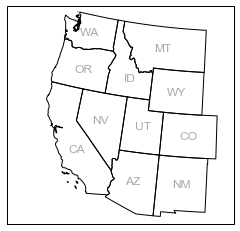

In [203]:
ax = plt.axes(projection=CONUS_WEST_PROJECTION)
fontscale=0.4
_w_states_records, _w_states_geoms = zip(*[(r, g) for r, g in zip(states.records(), states.geometries()) if r.attributes['name'].lower() in WESTERN_STATES])
ax.add_geometries(_w_states_geoms, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
ax.set_extent(CONUS_WEST_BBOX)

for label, label_geom in state_labels:
    ax.text(label_geom.x, label_geom.y, state_abbrevs[label.attributes['name'].lower()], transform=ccrs.PlateCarree(), horizontalalignment='center', verticalalignment='center', fontsize=30 * fontscale, alpha=0.4)

### Generic locator function

In [206]:
def plot_conus_locator(point, ax=None, fontscale=1, draw_labels=True):
    if not ax:
        ax = plt.axes(projection=CONUS_WEST_PROJECTION)
    states = cfeature.shapereader.Reader("/Users/tony/Downloads/ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp")
    labels = cfeature.shapereader.Reader("ne_10m_admin_1_label_points/ne_10m_admin_1_label_points.shp")
    state_labels = [(r, g) for r, g in zip(labels.records(), labels.geometries()) if
                        (r.attributes['name']) 
                        and (r.attributes['sr_adm0_a3'] == "USA")
                        and (r.attributes['adm0_sr'] == 1)
                        and (r.attributes['name'].lower() in WESTERN_STATES)]
    state_abbrevs = {r.attributes['name'].lower() : r.attributes['postal'] for r in states.records() }
    _w_states_records, _w_states_geoms = zip(*[(r, g) for r, g in zip(states.records(), states.geometries()) if r.attributes['name'].lower() in WESTERN_STATES])
    ax.add_geometries(_w_states_geoms, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.set_extent(CONUS_WEST_BBOX)
    
    if draw_labels:
        for label, label_geom in state_labels:
            ax.text(label_geom.x, label_geom.y, state_abbrevs[label.attributes['name'].lower()], transform=ccrs.PlateCarree(), horizontalalignment='center', verticalalignment='center', fontsize=30 * fontscale, alpha=0.6)

    ax.plot(point[0], point[1], transform=ccrs.PlateCarree(), marker='.', markersize=20, markeredgecolor='black', color='red', markeredgewidth=1.5)
    ax.outline_patch.set_linewidth(0)


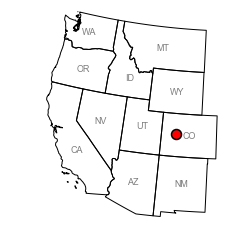

In [237]:
plot_conus_locator(GUNNISON_POINT, fontscale=0.3, draw_labels=True)

## Combined Figure. 

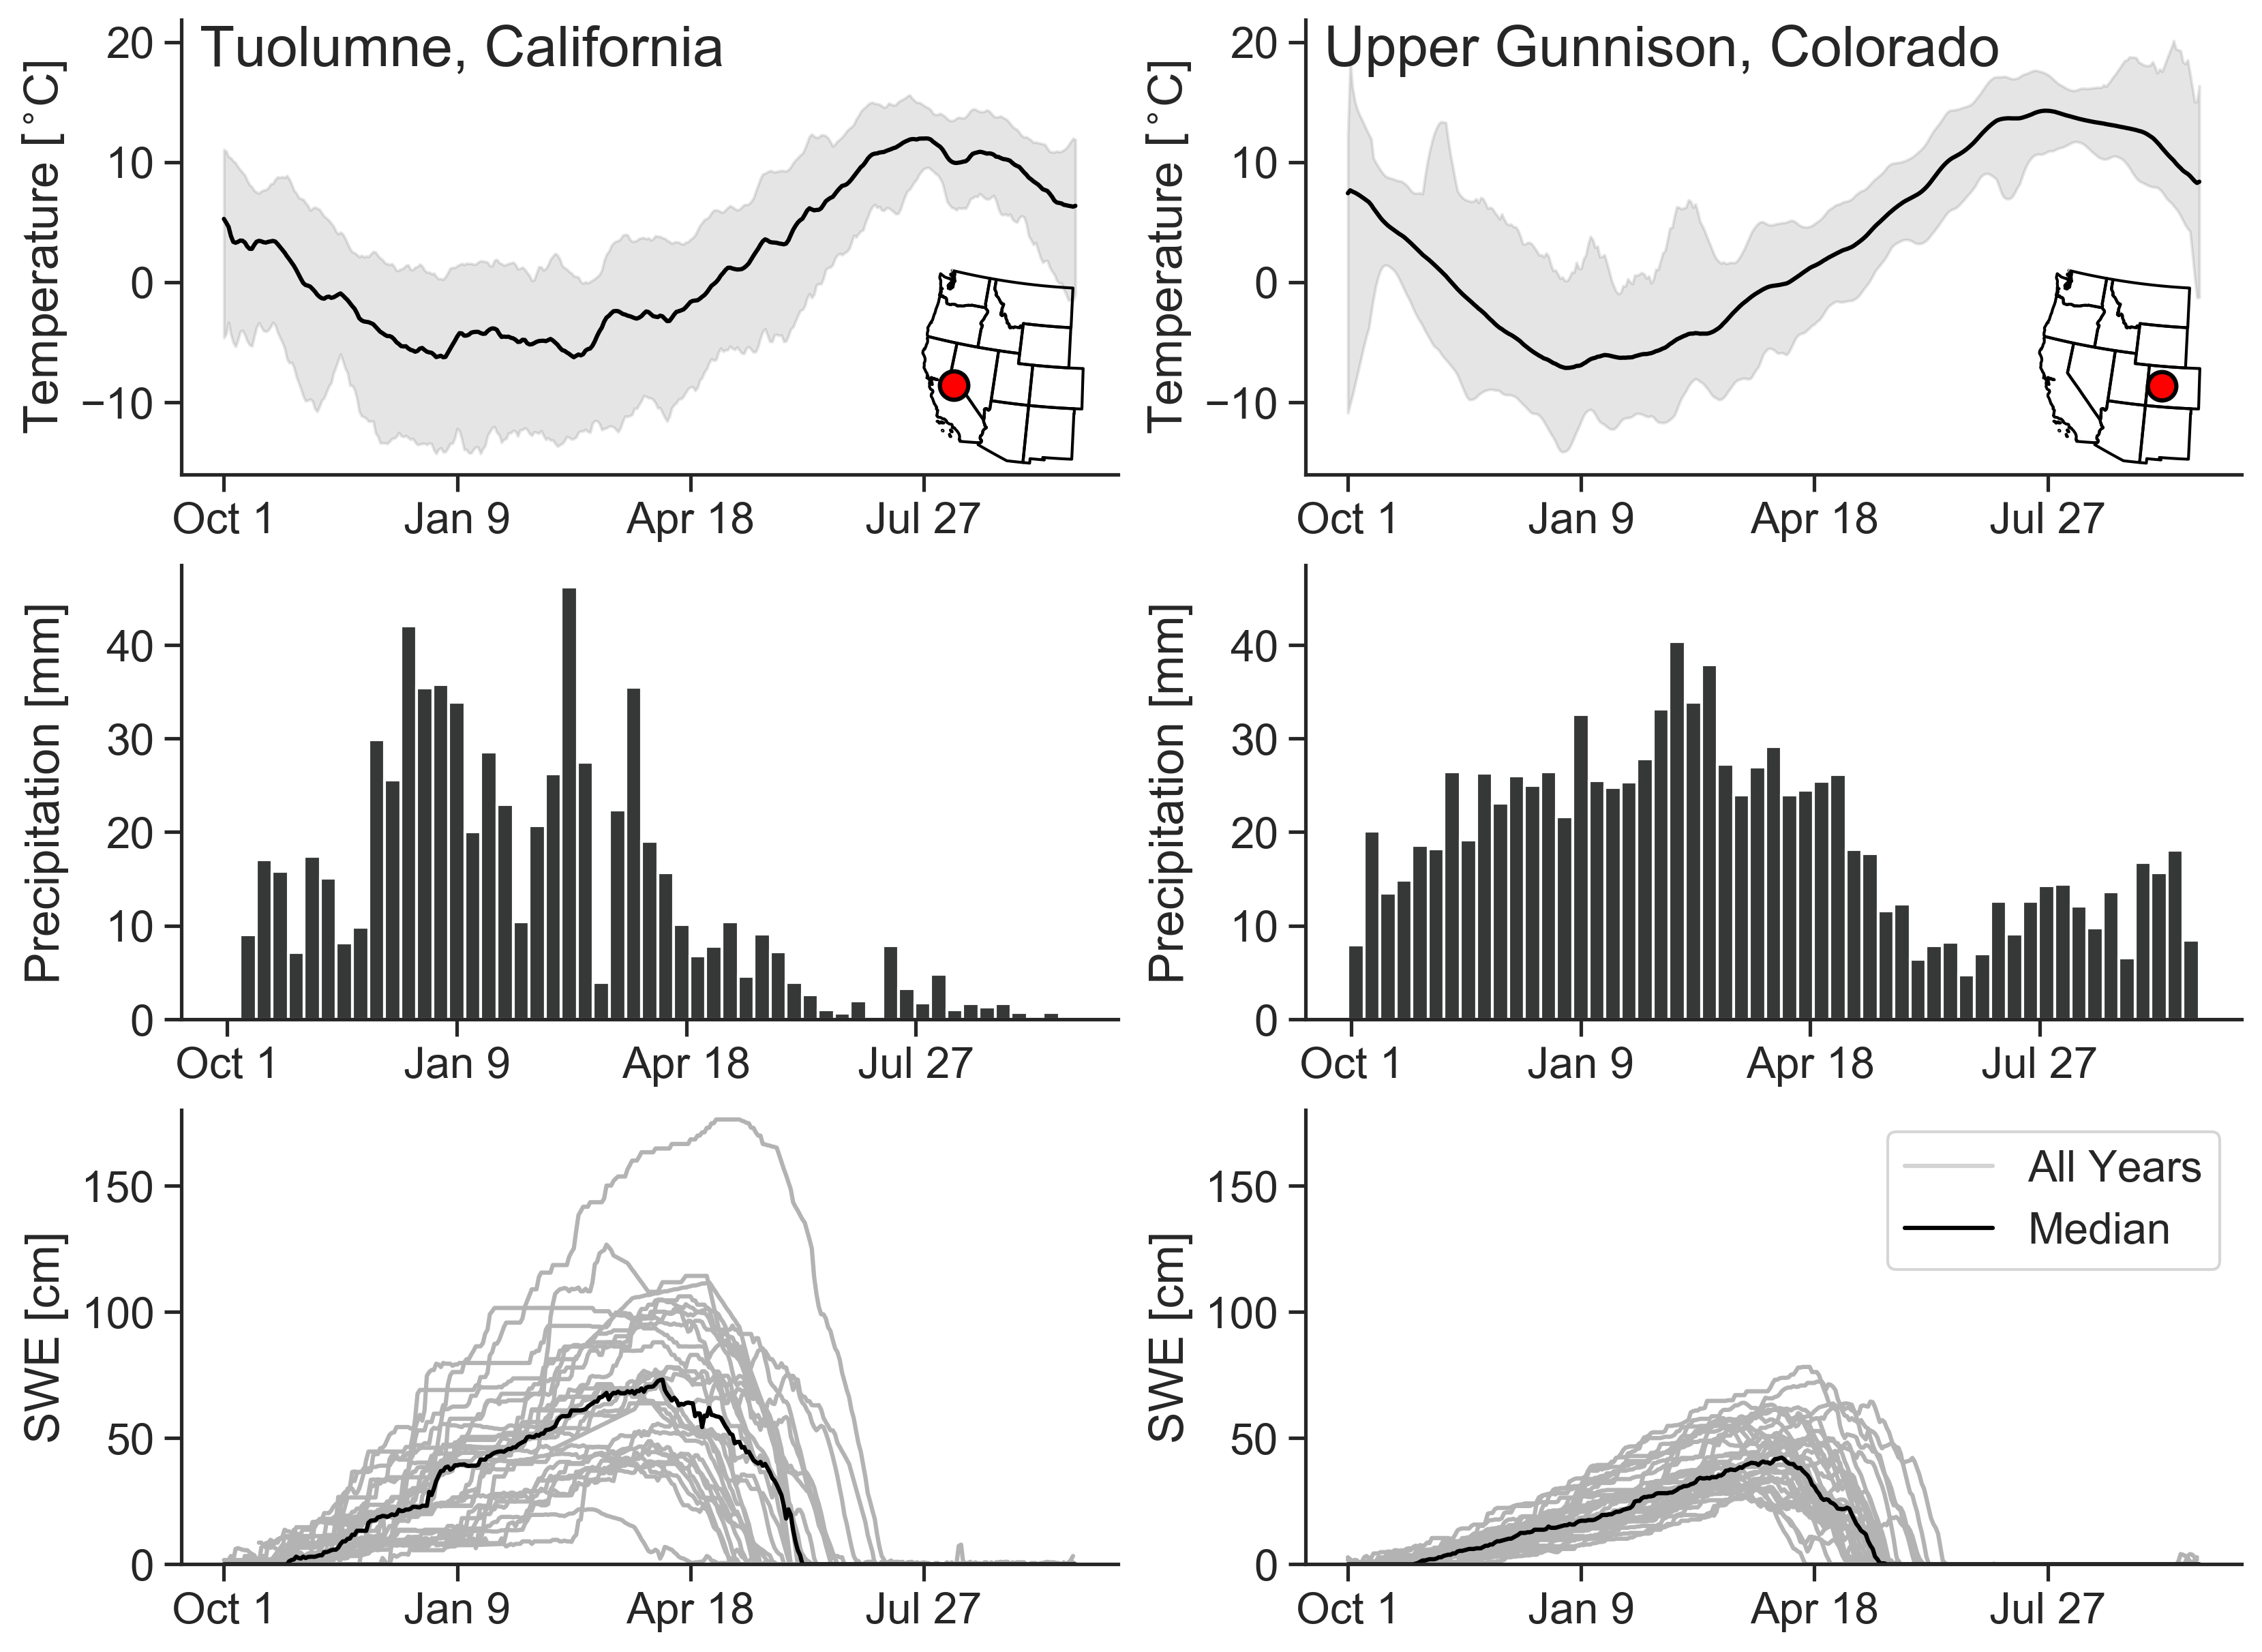

In [240]:
combined_fig = plt.figure(figsize=(13, 10), dpi=300)


main_gs = combined_fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1, 1, 1])

## TEMP_PLOTS
TEMP_gs = main_gs[0, :].subgridspec(1,2)

ca_temp = combined_fig.add_subplot(TEMP_gs[0])
plot_temp(dana_temp_daily, 'T_deg_C', ax=ca_temp)
ca_temp.set_ylabel("Temperature $[^{\circ}$C]")


co_temp = combined_fig.add_subplot(TEMP_gs[1], sharey=ca_temp)
plot_temp(co_tavg, "TAVG", ax=co_temp)
co_temp.set_ylabel("Temperature $[^{\circ}$C]")




## PRECIP PLOTS
PRECIP_gs = main_gs[1, :].subgridspec(1,2)

ca_precip = combined_fig.add_subplot(PRECIP_gs[0])
plot_precip(dana_pcp_wyd_weekly, "precip_m", ca_precip, color="xkcd:dark grey")
ca_precip.set_ylabel("Precipitation [mm]")


co_precip_ax = combined_fig.add_subplot(PRECIP_gs[1], sharey=ca_precip)
plot_precip(co_precip_wyd_weekly, 'pcp_adjusted', co_precip_ax, color='xkcd:dark grey', alpha=1)
co_precip_ax.set_ylabel("Precipitation [mm]")



## SWE PLOTS
SWE_gs = main_gs[2, :].subgridspec(1, 2)

tuolumne_swe = combined_fig.add_subplot(SWE_gs[0])
colorado_swe = combined_fig.add_subplot(SWE_gs[1], sharey=tuolumne_swe)

dana_minyear = dana_snotel["Date"].min().year
dana_maxyear = dana_snotel["Date"].max().year
title=""
plot_snow(cleaned_years, "DanaSWE", title, tuolumne_swe)

co_minyear = co_snotel.Date.min().year
co_maxyear = co_snotel.Date.max().year
# title = f"North Lost Trail SNOTEL, CO ({co_minyear}-{co_maxyear})"
title = ""
plot_snow(co_snotel, 'WTEQ', title, colorado_swe)

colorado_swe.legend(handles=[
    lines.Line2D([], [], color='lightgray', label="All Years"),
    lines.Line2D([], [], color='black', label="Median")
], loc='upper right')


## LABELS 
co_temp.text(0.02, .90, 'Upper Gunnison, Colorado', fontsize=20, transform=co_temp.transAxes)
ca_temp.text(0.02, .90, 'Tuolumne, California', fontsize=20, transform=ca_temp.transAxes)

# ## INSET LOCATORS 

ca_locator = combined_fig.add_axes([0.38, .66, 0.1, 0.1], projection=CONUS_WEST_PROJECTION)
plot_conus_locator(TUOLUMNE_POINT, fontscale=0.3, draw_labels=False, ax=ca_locator)
# plot_locator("california", CA_XY, ca_locator, fontscale=0)
ca_locator.outline_patch.set_visible(False)
ca_locator.background_patch.set_visible(False)


co_locator = combined_fig.add_axes([0.80, .66, 0.1, 0.1], projection=CONUS_WEST_PROJECTION)
plot_conus_locator(GUNNISON_POINT, fontscale=0.3, draw_labels=False, ax=co_locator)
# plot_locator("colorado", CO_XY, co_locator, fontscale=0)
co_locator.outline_patch.set_visible(False)
co_locator.background_patch.set_visible(False)

## cleanup + save
combined_fig.align_labels([ca_temp, ca_precip, tuolumne_swe])
combined_fig.align_labels([co_temp, co_precip_ax, colorado_swe])


plt.savefig("site_climatology_revisited.pdf", bbox_inches='tight')
plt.savefig("site_climatology_revisited.png", bbox_inches='tight', dpi=300)

